## Model Development

Author: Thomas Kulch

In [1]:
from src import database as db
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scripts import feature_engineering as fe


### Score prediction model

In [2]:
# connect to db
db = db.DatabaseManager()

In [3]:
# steps from 03_feature_eng
query = 'SELECT r.score, r.round_number,p.handicap, w.avg_temp, \
w.precipitation, w.wind_speed, w.day_of_week_int \
FROM rounds r \
LEFT JOIN players p ON r.player_id = p.player_id  \
LEFT JOIN weather w ON r.round_date = w.date'

results = db.execute_query(query)
df = pd.DataFrame(results)

In [4]:
# apply feature engineering and get features/target
X, y, scaler = fe.feature_engineering_with_scaling(df)

In [5]:
X.shape

(6458, 10)

In [6]:
y.shape

(6458,)

In [7]:
# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# initiate and train model
model = LinearRegression()
model.fit(X_train, y_train) # fit model
y_pred = model.predict(X_test) # get predictions

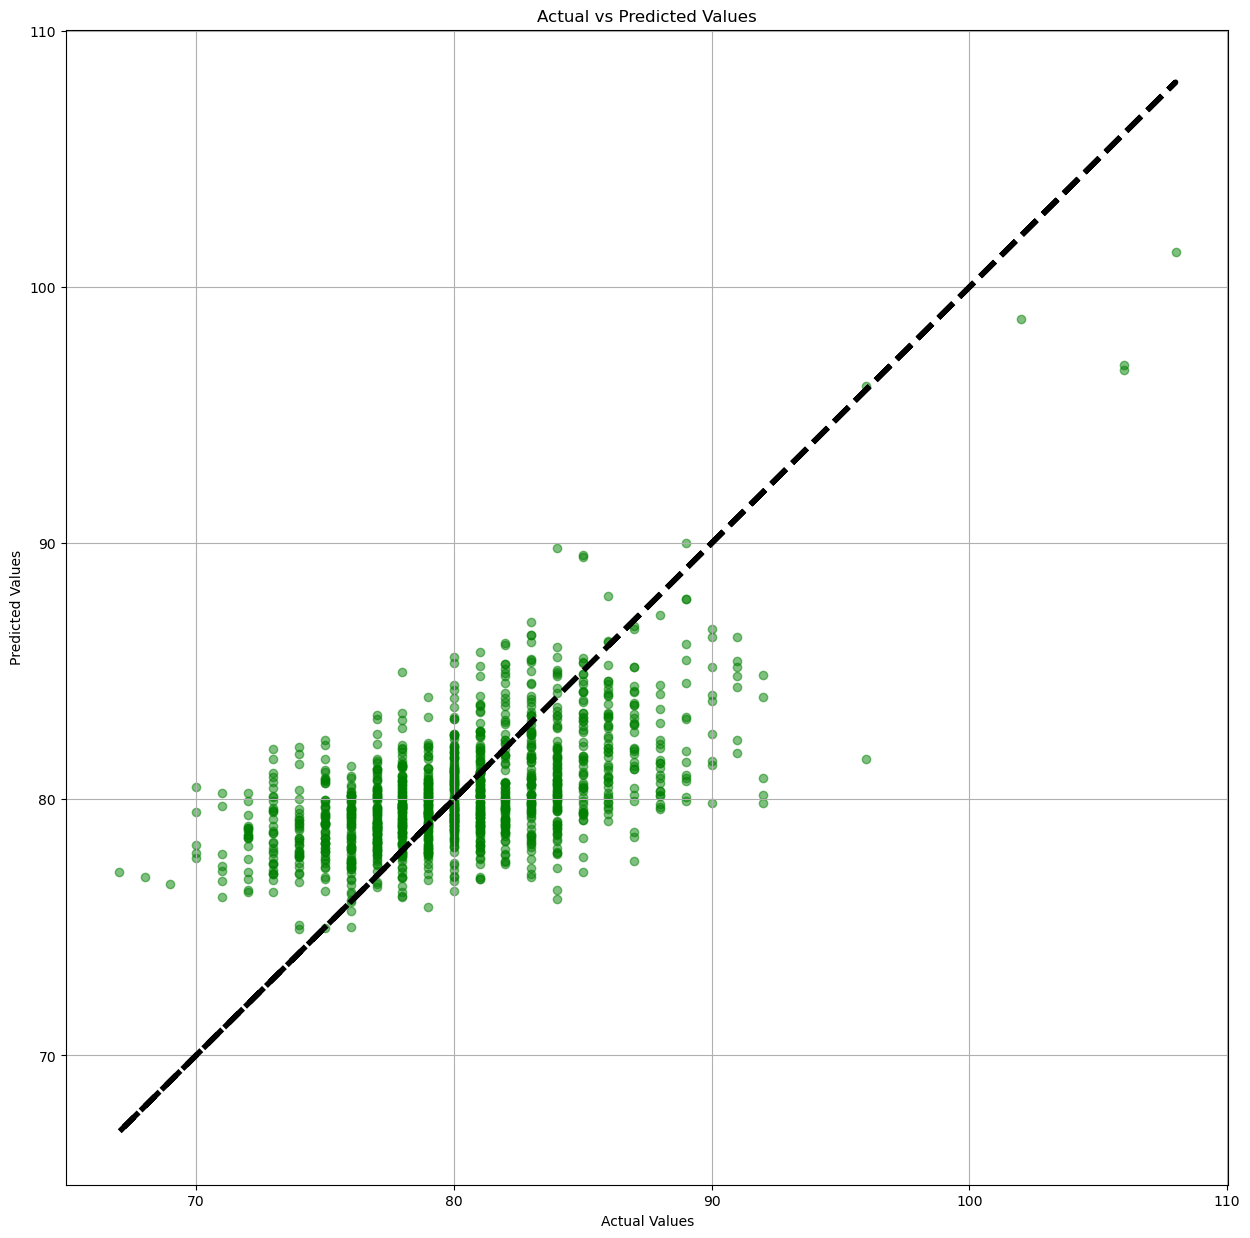

In [9]:
# create a plot to compare actual vs. predicted
plt.figure(figsize=(15,15))
plt.scatter(y_test, y_pred, color='green', alpha=0.5)

# add a line representing perfect predictions (y = x)
plt.plot(y_test, y_test, color='black',linestyle='dashed',linewidth=4)

# Add labels and title
plt.grid(True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Show plot
plt.show()

In [10]:
model.score(X_test, y_test)

0.3598711664225006

In [11]:
# mean and rmse
print('Mean of Predictions: ', y_pred.mean())
print('RMSE of Model: ', mean_squared_error(y_test,y_pred))

Mean of Predictions:  80.29574296688502
RMSE of Model:  12.41816858182686


We did not get good results with the Linear Regression model. This could be due to the model assuming all effects were independent rather than working together to influence score.

I will give the Ridge model a try and then move on to a tree based model

In [12]:
reg_model = Ridge(alpha=50,max_iter=100,tol=0.1)
reg_model.fit(X_train, y_train)

Ridge(alpha=50, max_iter=100, tol=0.1)

In [13]:
reg_model.score(X_test, y_test) # similar score. trying a random forest and GB model

0.3583160865604319

In [14]:
# random forest and gradient boosting regressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

In [15]:
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [16]:
rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)

In [17]:
r2_score(y_test,rf_pred) # slightly better than LR

0.3989502964255013

In [18]:
gb.score(X_test, y_test) # much better than LR

0.458254158864682

### Observations

Our gradient boosting model outperformed the other models.

45% accuracy is not bad considering it is really hard to predict a golf score. Anything can happen on any given day after all. We will use this model going forward.

In [19]:
# export model with joblib
import joblib

model_package_LR = {
    'model': model,
    'scaler': scaler,
    'feature_names': list(X.columns),
    'r2_score': model.score(X_test, y_test)
}

model_package_GB = {
    'model': gb,
    'scaler': scaler,
    'feature_names': list(X.columns),
    'r2_score': gb.score(X_test, y_test)
}

# save the model to models directory
joblib.dump(model_package_LR, '../data/models/model_LR.joblib')
joblib.dump(model_package_GB, '../data/models/model_GB.joblib')

# to load: model = joblib.load('../data/models/model_complete.joblib')

['../data/models/model_GB.joblib']

In [20]:
# test loading the model
model_test = joblib.load('../data/models/model_GB.joblib')
model_test['feature_names']

['round_number',
 'handicap',
 'avg_temp',
 'precipitation',
 'wind_speed',
 'day_of_week_int',
 'wind_precip',
 'wind_cold',
 'bad_weather_combo',
 'weekend']